In [7]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine, delete, Table, MetaData
import seaborn as sns 
import matplotlib.pyplot as plt

In [15]:
DB_PARAMS = {
    'dbname': 'postgres',   # Replace with your database name
    'user': 'postgres',         # Replace with your PostgreSQL user
    'password': 'meomeo', # Replace with your PostgreSQL password
    'host': 'localhost',         # PostgreSQL server host
    'port': '5432'               # Default port for PostgreSQL
}

In [17]:
def read_sql(query):
# Read SQL to DataFrame
        conn = psycopg2.connect(**DB_PARAMS)
        df = pd.read_sql_query(query, conn)
        conn.close()
        return df

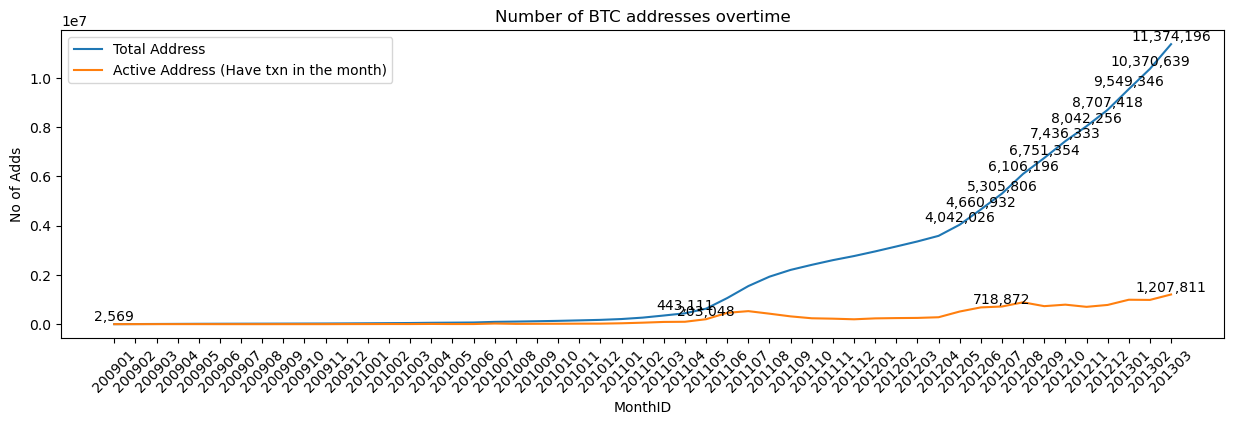

In [63]:
#df = read_sql('select count(*) total_address, count(case when count_outflow_month + count_inflow_month > 0 then addresses end ) active_address , month_id::text from fact_address_snapshot group by month_id order by month_id')
plt.figure(figsize=(15, 4))
ax = sns.lineplot(data = df, x = 'month_id', y = 'total_address', label='Total Address' )
ax2 = sns.lineplot(data = df, x = 'month_id', y = 'active_address',label='Active Address (Have txn in the month)'  )
plt.xticks(rotation=45)
plt.title('Number of BTC addresses overtime')
plt.xlabel('MonthID')
plt.ylabel('No of Adds')
for i, row in df[(df['month_id'] >= '201205' )| (df['month_id'] == '200901') | (df['month_id'] == '201104') ].iterrows():
    ax.text(x=row['month_id'], y=row['total_address'], s=f'{row["total_address"]:,}', color='black', ha='center', va='bottom')
for i, row in df[(df['month_id'] == '201105') | (df['month_id'] == '201207') | (df['month_id'] == '201303') ].iterrows():
    ax2.text(x=row['month_id'], y=row['active_address'], s=f'{row["active_address"]:,}', color='black', ha='center', va='bottom')
plt.legend(loc='upper left')
plt.show()

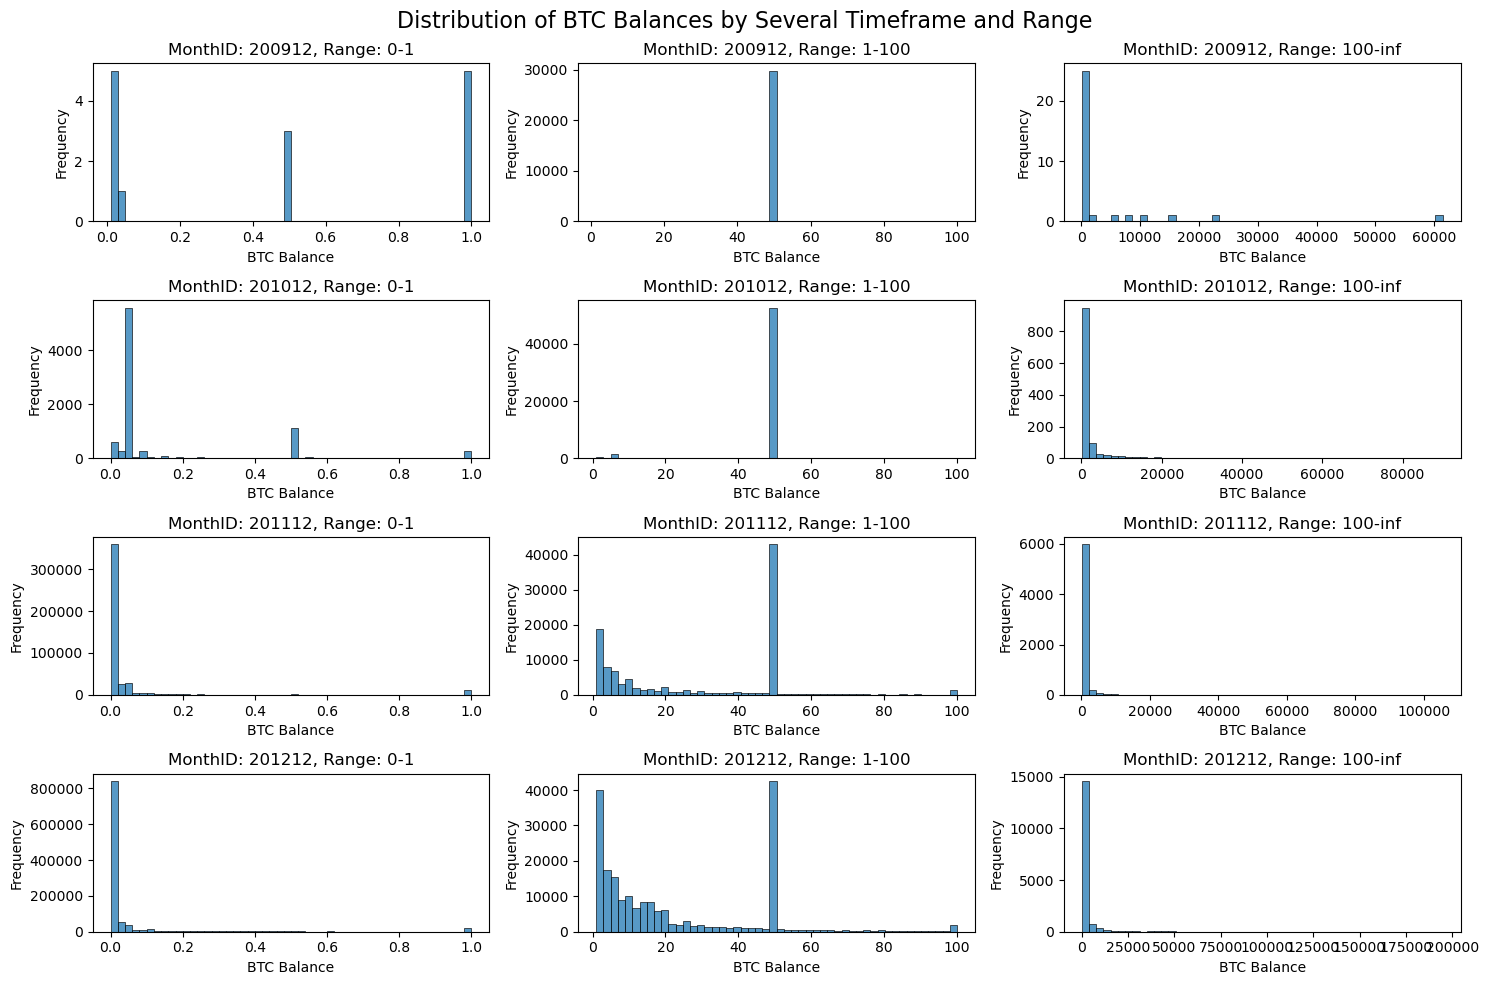

In [105]:
#df = read_sql('select month_id::text,btc_balance from fact_address_snapshot where month_id in (200912,201012,201112,201212) ')

balance_ranges = [(0, 1), (1, 100), (100, float('inf'))]
year_range = [200912, 201012, 201112, 201212]

fig, axes = plt.subplots(4, 3, figsize=(15, 10))

axes = axes.flatten()

for idx, year in enumerate(year_range):
    for j, (lower, upper) in enumerate(balance_ranges):
        data_filtered = df[(df['month_id'] == str(year)) & (df['btc_balance'] > lower) & (df['btc_balance'] <= upper)]
        
        sns.histplot(data_filtered, x="btc_balance", bins=50, kde=False, ax=axes[idx * 3 + j])
        
        axes[idx * 3 + j].set_title(f'MonthID: {year}, Range: {lower}-{upper}')
        axes[idx * 3 + j].set_xlabel('BTC Balance')
        axes[idx * 3 + j].set_ylabel('Frequency')
plt.suptitle('Distribution of BTC Balances by Several Timeframe and Range', fontsize=16)
plt.tight_layout()
plt.show()


/var/folders/np/yjbf57612_30_mjbr_d794yh0000gn/T/ipykernel_62694/352506468.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


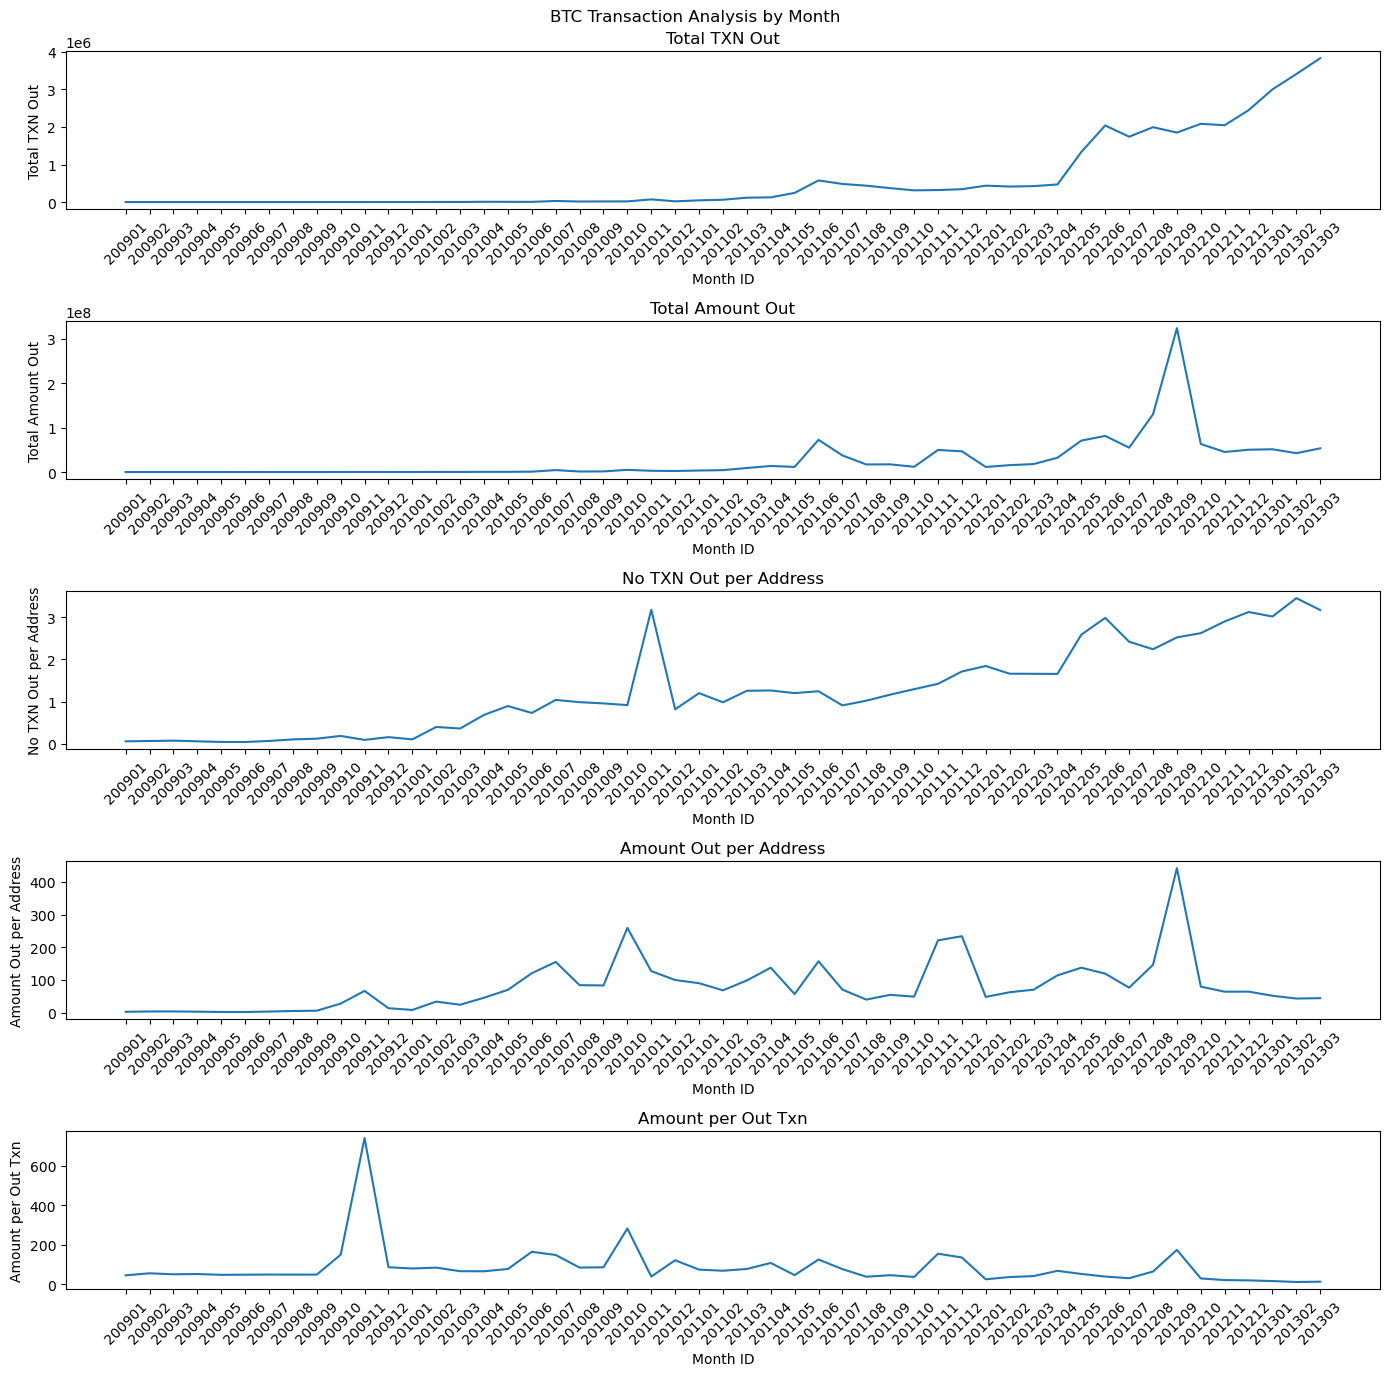

In [113]:

df = read_sql('''select 
sum(count_outflow_month) total_txn_out
,sum(sum_outflow_month) total_amt_out
,sum(sum_outflow_month)/sum(count_outflow_month) amt_per_txn
,sum(count_outflow_month)/count(case when count_outflow_month + count_inflow_month > 0 then addresses end ) txn_out_per_add
,sum(sum_outflow_month)/count(case when count_outflow_month + count_inflow_month > 0 then addresses end ) amt_out_per_add
,month_id::text 
from fact_address_snapshot
group by month_id 
 ''')

fig, axes = plt.subplots(5, 1, figsize=(14, 14))

axes = axes.flatten()

sns.lineplot(data=df, x='month_id', y='total_txn_out', ax=axes[0])
axes[0].set_title('Total TXN Out')
axes[0].set_xlabel('Month ID')
axes[0].set_ylabel('Total TXN Out')
axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis ticks

# Plot total_amt_out vs month_id
sns.lineplot(data=df, x='month_id', y='total_amt_out', ax=axes[1])
axes[1].set_title('Total Amount Out')
axes[1].set_xlabel('Month ID')
axes[1].set_ylabel('Total Amount Out')
axes[1].tick_params(axis='x', rotation=45)  # Rotate x-axis ticks

# Plot txn_out_per_add vs month_id
sns.lineplot(data=df, x='month_id', y='txn_out_per_add', ax=axes[2])
axes[2].set_title('No TXN Out per Address')
axes[2].set_xlabel('Month ID')
axes[2].set_ylabel('No TXN Out per Address')
axes[2].tick_params(axis='x', rotation=45)  # Rotate x-axis ticks

# Plot amt_out_per_add vs month_id
sns.lineplot(data=df, x='month_id', y='amt_out_per_add', ax=axes[3])
axes[3].set_title('Amount Out per Address')
axes[3].set_xlabel('Month ID')
axes[3].set_ylabel('Amount Out per Address')
axes[3].tick_params(axis='x', rotation=45)  # Rotate x-axis ticks

# Plot amt per txn vs month_id
sns.lineplot(data=df, x='month_id', y='amt_per_txn', ax=axes[4])
axes[4].set_title('Amount per Out Txn')
axes[4].set_xlabel('Month ID')
axes[4].set_ylabel('Amount per Out Txn')
axes[4].tick_params(axis='x', rotation=45)  # Rotate x-axis ticks

plt.suptitle('BTC Transaction Analysis by Month' , fontsize=12)

plt.tight_layout()

plt.subplots_adjust(top=0.95)
